In [14]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf  # For tf.data
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.applications import EfficientNetB0

# IMG_SIZE is determined by EfficientNet model choice
IMG_SIZE = 224
BATCH_SIZE = 64

In [15]:
dataset_name = "stanford_dogs"
(ds_train, ds_test), ds_info = tfds.load(
    dataset_name, split=["train", "test"], with_info=True, as_supervised=True
)
NUM_CLASSES = ds_info.features["label"].num_classes

size = (IMG_SIZE, IMG_SIZE)
ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))
ds_test = ds_test.map(lambda image, label: (tf.image.resize(image, size), label))


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/stanford_dogs/incomplete.LVACDX_0.2.0/stanford_dogs-train.tfrecord*...:   …

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/stanford_dogs/incomplete.LVACDX_0.2.0/stanford_dogs-test.tfrecord*...:   0…

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


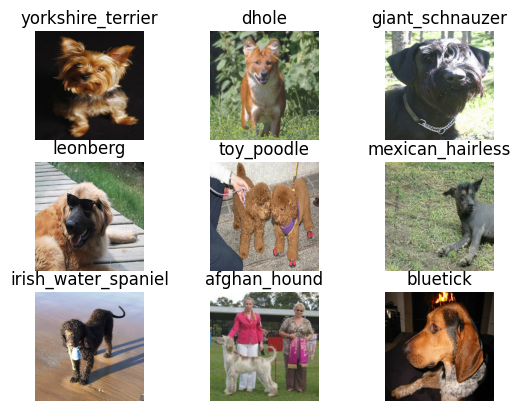

In [16]:
def format_label(label):
    string_label = label_info.int2str(label)
    return string_label.split("-")[1]


label_info = ds_info.features["label"]
for i, (image, label) in enumerate(ds_train.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title("{}".format(format_label(label)))
    plt.axis("off")

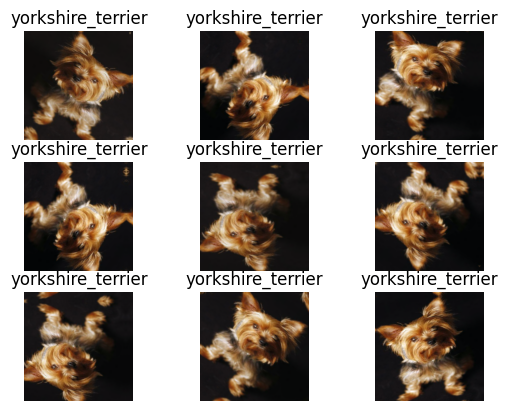

In [17]:
img_augmentation_layers = [
    layers.RandomRotation(factor=0.15),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomFlip(),
    layers.RandomContrast(factor=0.1),
]


def img_augmentation(images):
    for layer in img_augmentation_layers:
        images = layer(images)
    return images

for image, label in ds_train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = img_augmentation(np.expand_dims(image.numpy(), axis=0))
        aug_img = np.array(aug_img)
        plt.imshow(aug_img[0].astype("uint8"))
        plt.title("{}".format(format_label(label)))
        plt.axis("off")

In [18]:
# One-hot / categorical encoding
def input_preprocess_train(image, label):
    image = img_augmentation(image)
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


def input_preprocess_test(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


ds_train = ds_train.map(input_preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.batch(batch_size=BATCH_SIZE, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(input_preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(batch_size=BATCH_SIZE, drop_remainder=True)

In [19]:
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import EfficientNetB0

def build_sequential_model(num_classes):
    model = models.Sequential()
    
    # Add EfficientNetB0 as the base
    base_model = EfficientNetB0(include_top=False, weights="imagenet", input_shape=(IMG_SIZE, IMG_SIZE, 3))
    base_model.trainable = False  # Freeze the base model
    model.add(base_model)
    
    # Add custom layers on top
    model.add(layers.GlobalAveragePooling2D(name="avg_pool"))
    
    # Dropout and Dense layers
    top_dropout_rate = 0.2
    model.add(layers.Dropout(top_dropout_rate, name="top_dropout"))
    model.add(layers.Dense(num_classes, activation="softmax", name="pred"))

    # Compile the model
    optimizer = optimizers.Adam(learning_rate=1e-2)
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
    
    return model


In [20]:
# model.compile(optimizer='adam',
#               loss="categorical_crossentropy",
#               metrics=['accuracy'])

In [21]:
model = build_sequential_model(num_classes=NUM_CLASSES)

epochs = 25 # @param {type: "slider", min:1, max:100}
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test)
# plot_hist(hist)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/25


I0000 00:00:1727225411.340682      76 service.cc:145] XLA service 0x562074db1290 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727225411.340743      76 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1727225411.340749      76 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  2/187 ━━━━━━━━━━━━━━━━━━━━ 17s 94ms/step - accuracy: 0.0039 - loss: 4.9968       

I0000 00:00:1727225435.131065      76 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


187/187 ━━━━━━━━━━━━━━━━━━━━ 125s 491ms/step - accuracy: 0.2800 - loss: 3.3489 - val_accuracy: 0.6965 - val_loss: 1.0374
Epoch 2/25
187/187 ━━━━━━━━━━━━━━━━━━━━ 88s 470ms/step - accuracy: 0.4810 - loss: 2.1816 - val_accuracy: 0.7155 - val_loss: 1.0157
Epoch 3/25
187/187 ━━━━━━━━━━━━━━━━━━━━ 88s 468ms/step - accuracy: 0.5174 - loss: 2.0819 - val_accuracy: 0.7334 - val_loss: 0.9847
Epoch 4/25
187/187 ━━━━━━━━━━━━━━━━━━━━ 87s 467ms/step - accuracy: 0.5379 - loss: 2.0124 - val_accuracy: 0.7368 - val_loss: 1.0030
Epoch 5/25
187/187 ━━━━━━━━━━━━━━━━━━━━ 87s 466ms/step - accuracy: 0.5493 - loss: 1.9968 - val_accuracy: 0.7382 - val_loss: 1.0525
Epoch 6/25
187/187 ━━━━━━━━━━━━━━━━━━━━ 87s 467ms/step - accuracy: 0.5623 - loss: 1.9660 - val_accuracy: 0.7348 - val_loss: 1.0627
Epoch 7/25
187/187 ━━━━━━━━━━━━━━━━━━━━ 88s 468ms/step - accuracy: 0.5728 - loss: 1.9709 - val_accuracy: 0.7367 - val_loss: 1.0776
Epoch 8/25
187/187 ━━━━━━━━━━━━━━━━━━━━ 87s 465ms/step - accuracy: 0.5848 - loss: 1.9521 - va

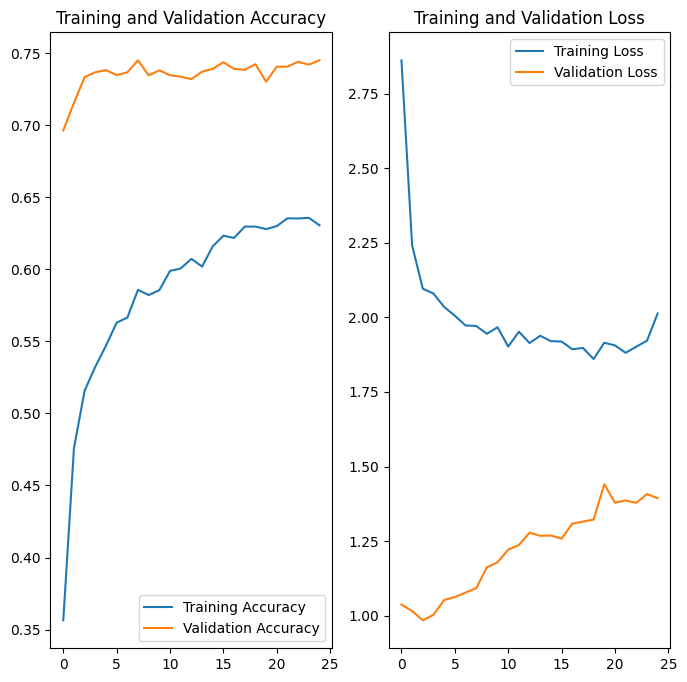

In [22]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [23]:
# Save the entire model as a `.keras` zip archive.
model.save('Breed_model.keras')

In [24]:
new_model = tf.keras.models.load_model('Breed_model.keras')

# Show the model architecture
new_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (64, 7, 7, 1280)       │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ avg_pool                        │ (64, 1280)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ top_dropout (Dropout)           │ (64, 1280)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pred (Dense)                    │ (64, 120)              │       153,720 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,510,733 (17.21 MB)

 Trainable params: 153,720 (600.47 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

 Optimizer params: 307,442 (1.17 MB)

In [25]:
# Evaluate the restored model
loss, acc = new_model.evaluate(ds_test)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

# print(new_model.predict(test_images).shape)

134/134 ━━━━━━━━━━━━━━━━━━━━ 14s 62ms/step - accuracy: 0.7726 - loss: 1.2050
Restored model, accuracy: 76.70%
